In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import io
import os
import functools

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from preprocessing import read_dataset
from preprocessing import Tokenization, StopWordsRemover, Lemmatization, RoofRemoval, SpellingCorrection
from preprocessing import GibberishDetector, TokenGrouping, TokenDictionary, SentimentAnalysis

from csv_parser import split_train_test

import features as F
from models import MajorityModel, SklearnModel, CRFModel
from cross_validation import cross_validate
from evaluation import Evaluator

## Read and preprocess data

In [3]:
# Read data

dataset_path = 'data/discussion_data.csv'
df = read_dataset(dataset_path)
df['Message Time'] = pd.to_datetime(df['Message Time'])
tags = df.CategoryBroad.unique()

In [4]:
# Tokenization, lemmatization, roof removal
tokenizer = Tokenization()
stop_words_remover = StopWordsRemover('data/stopwords-sl-custom.txt')
lemmatizer = Lemmatization()
roof_removal = RoofRemoval()

# spelling_correction = SpellingCorrection('data/dict-sl.txt', roof_removal)

# Gibberish detector
gibberish_detector = GibberishDetector(roof_removal)
gibberish_detector.train('data/dict-sl.txt', 'data/gibberish_good.txt', 'data/gibberish_bad.txt')

# Token grouping
token_grouping = TokenGrouping(gibberish_detector)

sa = SentimentAnalysis('data/negative_words_Slolex.txt', 'data/positive_words_Slolex.txt', roof_removal)

Correct good: 1.0
Correct bad: 1.0


In [5]:
# Tokenize the books
book_tokens = {}
for book in os.listdir('data/books'):
    book_id = int(book.split('.')[0])
    with io.open(os.path.join('data/books', book), mode='r', encoding='utf-8') as f:
        content = f.read()
        tokens = tokenizer.tokenize(content)
        tokens = stop_words_remover.remove_stopwords(tokens)
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        tokens = [roof_removal.remove(token) for token in tokens]
        tokens = [token_grouping.group_tokens(token) for token in tokens]
        # remove gibberish and punctuations
        tokens = [token for token in tokens if token.isalpha() and not token == '<other>']
        book_tokens[book_id] = tokens

In [6]:
# Tokenize the topics
topics_tokens = {}
for topic in df['Topic'].unique():
    tokens = tokenizer.tokenize(topic)
    tokens = stop_words_remover.remove_stopwords(tokens)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [roof_removal.remove(token) for token in tokens]
    tokens = [token_grouping.group_tokens(token) for token in tokens]
    # remove gibberish and punctuations
    tokens = [token for token in tokens if token.isalpha() and not token == '<other>']
    topics_tokens[topic] = tokens

In [7]:
# Tokenize the messages
messages_sent = []
for message in df.Message:
    tokens = tokenizer.tokenize(message)
    tokens = stop_words_remover.remove_stopwords(tokens)
    messages_sent.append(tokens)

messages = []
for tokens in messages_sent:
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [roof_removal.remove(token) for token in tokens]
    tokens = [token_grouping.group_tokens(token) for token in tokens]
    messages.append(tokens)

In [8]:
# Create BoW dictionary
token_dict_msg = TokenDictionary(messages, dict_size=512)
token_dict_context = TokenDictionary(list(book_tokens.values()) + list(topics_tokens.values()), dict_size=512)

In [9]:
# Create BoW of ngrams
ngram_arr = F.build_ngram_model([msg.split() for msg in df.Message], 2)
ngram_dict = TokenDictionary(ngram_arr, dict_size=1024)

In [10]:
# Get tf-idf weighted BoW representations
bow = np.stack([token_dict_msg.bag_of_words(message) for message in messages])
bow_tfidf = np.stack([token_dict_msg.bag_of_words(message, tf_idf=True) for message in messages])

context_bow = np.stack([token_dict_context.bag_of_words(message) for message in messages])
context_bow_tfidf = np.stack([token_dict_context.bag_of_words(message, tf_idf=True) for message in messages])

# Get ngram model
ngram_model = np.stack([ngram_dict.bag_of_words(ngram) for ngram in ngram_arr])

## Cross validation

In [11]:
# Create split
kFolds = split_train_test(df)

['OŠ Ketteja in Murna' 'OŠ Franca Rozmana Staneta' 'OŠ Nove Fužine'
 'OŠ Alojzija Šuštarja' 'OŠ Vižmarje - Brod' 'OŠ Vide Pregarc'
 'OŠ Valentina Vodnika' 'OŠ Koseze']


In [12]:
# Create models
model1 = SklearnModel(LinearSVC(max_iter=4000))
model2 = SklearnModel(RandomForestClassifier(n_estimators=500))
model3 = CRFModel('test')

models = [model1, model2, model3]

In [13]:
# Create base feature functions
fn_length = functools.partial(F.length, df=df)
fn_wordcount = functools.partial(F.wordcount, df=df)
fn_recent_activity = functools.partial(F.recent_activity, df=df)
fn_sentiment = functools.partial(F.sentiment, messages=messages_sent, sentiment_analysis=sa, normalize=True)

fn_msg_bow = functools.partial(F.message_bow, bow_values=bow_tfidf, name='bow_msg')
fn_ngram_bow = functools.partial(F.message_bow, bow_values=ngram_model, name='bow_ngram')
fn_context_bow = functools.partial(F.message_bow, bow_values=context_bow_tfidf, name='bow_ctx')

In [14]:
# Create feature functions combinations
feature_fn1 = F.merge_feature_functions([
    fn_length,
    fn_wordcount,
    fn_sentiment,
    fn_recent_activity
])

feature_fn2 = F.merge_feature_functions([
    fn_msg_bow,
    fn_ngram_bow
])

feature_fn3 = F.merge_feature_functions([
    fn_length,
    fn_wordcount,
    fn_msg_bow,
    fn_ngram_bow,
    fn_sentiment,
    fn_recent_activity,
    fn_context_bow
])


features_fns = [feature_fn1, feature_fn2, feature_fn3]

In [15]:
# Labels
labels_fn = functools.partial(F.get_label, df=df)

**Run cross-validation**

In [16]:
from tqdm import tqdm

In [17]:
# NOTE: Remove this line to perform full cross-validation
kFolds = kFolds[:1]

In [ ]:
evaluators_train = []
evaluators_test = []

for i, features_fn in enumerate(features_fns):
    evals_train = []
    evals_test = []
    
    # Get datasets
    folds_data = []
    print('Preparing data...')
    for train_dfs, test_dfs in tqdm(kFolds):
        X_train, y_train = F.dataframes_to_dataset(train_dfs, features_fn, labels_fn)
        X_test, y_test = F.dataframes_to_dataset(test_dfs, features_fn, labels_fn)

        data = ((X_train, y_train), (X_test,y_test))
        folds_data.append(data)
        
    for j, model in enumerate(models):
        print(f"Model {j+1}, feature set {i+1}")
        res = cross_validate(folds_data, model)
        train_preds, train_labels, test_preds, test_labels = res

        test_evaluator = Evaluator(test_preds, test_labels, tags)
        evals_test.append(test_evaluator)
        
        train_evaluator = Evaluator(train_preds, train_labels, tags)
        evals_train.append(train_evaluator)

    evaluators_train.append(evals_train)
    evaluators_test.append(evals_test)

In [19]:
f_scores = []
for feature_evals in evaluators_test:
    scores = np.array([evaluator.get_f1_measure() for evaluator in feature_evals])
    f_scores.append(scores)

f_scores = np.stack(f_scores)
rows = [f'FeatureSet {i+1}' for i in range(len(features_fns))]
cols = [f'Model {i+1}' for i in range(len(models))]

In [21]:
res_df = pd.DataFrame(data=f_scores, index=rows, columns=cols)
res_df

,Model 1,Model 2,Model 3
FeatureSet 1,0.309342,0.508307,0.489458
FeatureSet 2,0.649879,0.691582,0.758079
FeatureSet 3,0.621980,0.694411,0.785194


Confusion matrix:
     C   I   D   O  M  S
C  169   7  25   5  0  0
I   28  58   8   3  0  0
D   12   3  94   0  1  0
O   12   1   2  84  1  0
M    2   0   1   0  5  0
S    0   0   0   0  0  0

Accuracy : 0.7869
Precision: 0.7950
Recall   : 0.7869
F1 score : 0.7852
F! ave   : 0.6353


class  precision  recall     f1 score  

C      0.7578     0.8204     0.7879    
I      0.8406     0.5979     0.6988    
D      0.7231     0.8545     0.7833    
O      0.9130     0.8400     0.8750    
M      0.7143     0.6250     0.6667    
S      0.0000     0.0000     0.0000    



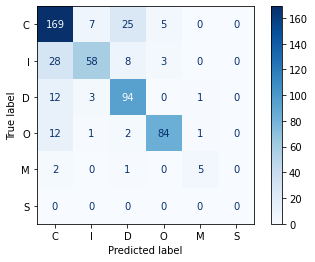

In [25]:
# Best model
i,j = np.unravel_index(f_scores.argmax(), f_scores.shape)
evaluators_test[i][j].get_classification_report(plot=True)